In [ ]:
import numpy as np
import math
import scipy as sp
import matplotlib.pyplot as plt
from scipy.io.wavfile import read as wavread
def ToolReadAudio(cAudioFilePath):    
    [samplerate, x] = wavread(cAudioFilePath)    
    if x.dtype == 'float32':        
        audio = x    
    else:        
        # change range to [-1,1)        
        if x.dtype == 'uint8':            
            nbits = 8        
        elif x.dtype == 'int16':            
            nbits = 16        
        elif x.dtype == 'int32':            
            nbits = 32        
        audio = x / float(2**(nbits - 1))    
        # special case of unsigned format    
    if x.dtype == 'uint8':        
        audio = audio - 1.    
    return (samplerate, audio)
def block_audio(x,blockSize,hopSize,fs):
    # allocate memory
    numBlocks = math.ceil(x.size / hopSize)
    xb = np.zeros([numBlocks, blockSize])
    # compute time stamps
    t = (np.arange(0, numBlocks) * hopSize) / fs
    x = np.concatenate((x, np.zeros(blockSize)),axis=0)
    for n in range(0, numBlocks):
        i_start = n * hopSize
        i_stop = np.min([x.size - 1, i_start + blockSize - 1])
        xb[n][np.arange(0,blockSize)] = x[np.arange(i_start, i_stop + 1)]
    return (xb,t)

In [115]:
fs=44100
test_aud = np.sin(2*np.pi*1500*np.arange(1 * fs)/fs)
test_blocked,t = block_audio(test_aud,2048, 1024, fs)
print(math.ceil(test_aud.size / 1024))

44


# A. Maximum spectral peak based pitch tracker 


- [5 points] Implement a function [X, fInHz] = compute_spectrogram(xb, fs) that computes the magnitude spectrum for each block of audio in xb (calculated using the reference block_audio() from previous assignments) and returns the magnitude spectrogram X (dimensions blockSize/2+1 X numBlocks) and a frequency vector fInHz (dim blockSize/2+1,) containing the central frequency of each bin. Do not use any third party spectrogram function. Note: remove the redundant part of the spectrum. Also note that you will have to apply a von-Hann window of appropriate length to the blocks before computing the fft. 
   
- [10 points] Implement a function: [f0, timeInSec] = track_pitch_fftmax(x, blockSize, hopSize, fs) that estimates the fundamental frequency f0 of the audio signal based on a block-wise maximum spectral peak finding approach. Note: This function should use compute_spectrogram().  
  
- [5 points] If the blockSize = 1024 for blocking, what is the exact time resolution of your pitch tracker? Can this be improved without changing the block-size? If yes, how? If no, why? (Use a sampling rate of 44100Hz for all calculations).  

## Spectrogram

In [131]:
def compute_hann(iWindowLength):
    return 0.5 - (0.5 * np.cos(2 * np.pi / iWindowLength * 
np.arange(iWindowLength)))
def compute_spectrogram(xb,fs):
    numBlocks = xb.shape[0]
    afWindow = compute_hann(xb.shape[1])
    X = np.zeros([math.ceil(xb.shape[1]/2+1), numBlocks])
    freq=np.fft.fftfreq(xb[0].size,1/fs)
    freqs = freq[:int(xb[0].size/2)+1]
    for n in range(0, numBlocks):
        # apply window
        tmp = abs(np.fft.fft(xb[n,:] * afWindow))*2/xb.shape[1]
        # freq=np.fft.fftfreq(xb[0].size,1/fs)
        # freqs[n]=freq[:int(xb[0].size/2)+1]
        # compute magnitude spectum
        X[:,n] = tmp[range(math.ceil(tmp.size/2+1))] 
        X[[0,math.ceil(tmp.size/2)],n]= X[[0,math.ceil(tmp.size/2)],n]/np.sqrt(2) 
    return X,freqs

### Testing Spectrogram

In [132]:
S,f = compute_spectrogram(test_blocked, 44100)

In [133]:
S.shape

(1025, 44)

In [152]:
f[np.argmax(S.T[0])]

1507.32421875

In [160]:
def plot_spectrogram(spectrogram, fs, hopSize):
    t = hopSize*np.arange(spectrogram.shape[1])/fs
    f = np.arange(0,fs/2, fs/2/spectrogram.shape[0])

    plt.figure(figsize = (15, 7))
    plt.xlabel('Time (s)')
    plt.ylabel('Freq (Hz)')
    plt.pcolormesh(t, f, spectrogram)
    plt.show()

<ipython-input-160-3e366e55ef79>:8: MatplotlibDeprecationWarning:

shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.



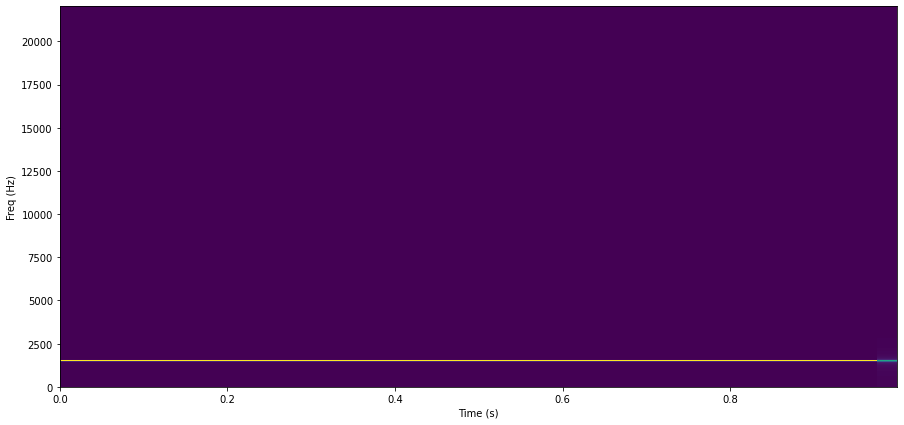

In [161]:
plot_spectrogram(S,44100,1024)

Plotting spectrum to test

In [153]:
import plotly.express as px
px.line(y=S.T[0][:-1],x=f[:-1])

## At blocksize = 1024: time resolution = 0.011609977324263039 s
Time resolution = hopSize / fs (assuming hopSize = blockSize/2, we get time resolution = blockSize/2fs)

In [181]:
1024/44100

0.023219954648526078

In [180]:
def block_audio(x,blockSize,hopSize,fs):
    # allocate memory
    numBlocks = math.ceil(x.size / hopSize)
    xb = np.zeros([numBlocks, blockSize])
    # compute time stamps
    t = (np.arange(0, numBlocks) * hopSize) / fs
    x = np.concatenate((x, np.zeros(blockSize)),axis=0)
    for n in range(0, numBlocks):
        i_start = n * hopSize
        i_stop = np.min([x.size - 1, i_start + blockSize - 1])
        xb[n][np.arange(0,blockSize)] = x[np.arange(i_start, i_stop + 1)]
    return (xb,t)

_,t=block_audio(test_aud,1024,512,44100)
print(t[1]-t[0])
_,t=block_audio(test_aud,2048,1024,44100)
print(t[1]-t[0])

0.011609977324263039
0.023219954648526078


## [f0, timeInSec] = track_pitch_fftmax(x, blockSize, hopSize, fs) that estimates the fundamental frequency f0 of the audio signal based on a block-wise maximum spectral peak finding approach. Note: This function should use compute_spectrogram().

In [175]:
def track_pitch_fftmax(x,blockSize,hopSize,fs):
    xb,t = block_audio(x,blockSize,hopSize,fs)
    S,f=compute_spectrogram(xb,fs)
    numBlocks = S.T.shape[0]
    f0=np.zeros(numBlocks)
    for n in range(numBlocks):
        f0[n] = f[np.argmax(S.T[0])]
    return f0,t

In [179]:
f0,t = track_pitch_fftmax(test_aud,1024,512,44100)
px.line(x=t,y=f0)

# C. Voicing Detection

- [1 points] Take the  function [rmsDb] = extract_rms(xb) from the second assignment which takes the blocked audio as input and computes the RMS (Root Mean Square) amplitude of each block.
- [6 points] Implement a function [mask] = create_voicing_mask(rmsDb, thresholdDb) which takes a vector of decibel values for the different blocks of audio and creates a binary mask based on the threshold parameter. Note: A binary mask in this case is a simple column vector of the same size as 'rmsDb' containing 0's and 1's only. The value of the mask at an index is 0 if the rmsDb value at that index is less than 'thresholdDb' and the value is 1 if 'rmsDb' value at that index is greater than or equal to the threshold. 
- [6 points] Implement a function [f0Adj] = apply_voicing_mask(f0, mask)  which applies the voicing mask to the previously computed f0 so that the f0 of blocks with low energy is set to 0.

## Take the  function [rmsDb] = extract_rms(xb) from the second assignment which takes the blocked audio as input and computes the RMS (Root Mean Square) amplitude of each block.

In [182]:
def extract_rms(xb):
    # number of results
    numBlocks = xb.shape[0]
    # allocate memory
    vrms = np.zeros(numBlocks)
    for n in range(0, numBlocks):
        # calculate the rms
        vrms[n] = np.sqrt(np.dot(xb[n,:], xb[n,:]) / xb.shape[1])
    # convert to dB
    epsilon = 1e-5  # -100dB
    vrms[vrms < epsilon] = epsilon
    vrms = 20 * np.log10(vrms)
    return (vrms)

## [mask] = create_voicing_mask(rmsDb, thresholdDb) which takes a vector of decibel values for the different blocks of audio and creates a binary mask based on the threshold parameter.

In [183]:
def create_voicing_mask(rmsDb,thresholdDb):
    # mask = np.zeros(rmsDb.shape[0])
    f = lambda x : 1 if x > thresholdDb else 0
    apply_threshold = np.vectorize(f)
    return(apply_threshold(rmsDb))

### Testing create_voicing_mask

In [185]:
rms=np.array([100,101,200,1,3,5,50])
thresh = 30
create_voicing_mask(rms,thresh)

array([1, 1, 1, 0, 0, 0, 1])

## [f0Adj] = apply_voicing_mask(f0, mask)  which applies the voicing mask to the previously computed f0 so that the f0 of blocks with low energy is set to 0.

In [193]:
def apply_voicing_mask(f0,mask):
    return(f0*mask)

### Testing apply_voicing_mask

In [190]:
randomLabel = np.random.randint(2, size=f0.shape[0])

In [194]:
randomLabel * f0

array([   0.        ,    0.        ,    0.        ,    0.        ,
          0.        , 1507.32421875, 1507.32421875, 1507.32421875,
       1507.32421875,    0.        , 1507.32421875, 1507.32421875,
          0.        , 1507.32421875,    0.        ,    0.        ,
       1507.32421875, 1507.32421875, 1507.32421875, 1507.32421875,
       1507.32421875,    0.        ,    0.        ,    0.        ,
          0.        ,    0.        , 1507.32421875,    0.        ,
          0.        , 1507.32421875,    0.        ,    0.        ,
       1507.32421875,    0.        ,    0.        ,    0.        ,
       1507.32421875, 1507.32421875,    0.        ,    0.        ,
       1507.32421875,    0.        ,    0.        ,    0.        ,
       1507.32421875, 1507.32421875,    0.        , 1507.32421875,
       1507.32421875, 1507.32421875, 1507.32421875,    0.        ,
       1507.32421875,    0.        ,    0.        ,    0.        ,
       1507.32421875, 1507.32421875,    0.        ,    0.     

# D. Different evaluation metrics
- [5 points] Implement a function [pfp] = eval_voiced_fp(estimation, annotation) that computes the percentage of false positives for your fundamental frequency estimation
False Positive : The denominator would be the number of blocks for which annotation = 0. The numerator would be how many of these blocks were classified as voiced (with a fundamental frequency not equal to 0) is your estimation. 
- [5 points] Implement a function [pfn] = eval_voiced_fn(estimation, annotation) that computes the percentage of false negatives for your fundamental frequency estimation
False Negative: In this case the denominator would be number of blocks which have non-zero fundamental frequency in the annotation. The numerator would be number of blocks out of these that were detected as zero is the estimation.
- [5 points] Now modify the eval_pitchtrack() method that you wrote in Assignment 1 to [errCentRms, pfp, pfn] = eval_pitchtrack_v2(estimation, annotation), to return all the 3 performance metrics for your fundamental frequency estimation.  Note: the errorCentRms computation might need to slightly change now considering that your estimation might also contain zeros.

## [5 points] Implement a function [pfp] = eval_voiced_fp(estimation, annotation) that computes the percentage of false positives for your fundamental frequency estimation
False Positive : The denominator would be the number of blocks for which annotation = 0. The numerator would be how many of these blocks were classified as voiced (with a fundamental frequency not equal to 0) is your estimation. 

In [210]:
def eval_voiced_fp(estimation, annotation):
    m = (annotation==0)
    denom=m.sum()
    num = ((m*estimation) > 0).sum()
    pfp = num/denom
    return pfp

### Testing eval_voiced_fp

In [211]:
est = np.array([0,1,1,0])
ann = np.array([1,0,0,0])
eval_voiced_fp(est,ann)

0.6666666666666666

## [5 points] Implement a function [pfn] = eval_voiced_fn(estimation, annotation) that computes the percentage of false negatives for your fundamental frequency estimation
False Negative: In this case the denominator would be number of blocks which have non-zero fundamental frequency in the annotation. The numerator would be number of blocks out of these that were detected as zero is the estimation.

In [227]:
def eval_voiced_fn(estimation, annotation):
    m = (annotation!=0)
    denom=m.sum()
    # Adding one to all elements in estimation so that only elements that are non-zero in annotation are set to zero in the calculation below:
    num = ((m*(estimation+1)) == 1).sum()  # counting number of elements that are non zero in annotation but 1 in annotation (after adding one to every element)
    pfn = num/denom
    return pfn

### Testing eval_voiced_fn

In [229]:
est = np.array([0,1,1,0,0])
ann = np.array([1,1,1,0,1])
eval_voiced_fn(est,ann)
# (ann!=0)*est

0.5

## [5 points] Now modify the eval_pitchtrack() method that you wrote in Assignment 1 to [errCentRms, pfp, pfn] = eval_pitchtrack_v2(estimation, annotation), to return all the 3 performance metrics for your fundamental frequency estimation.  Note: the errorCentRms computation might need to slightly change now considering that your estimation might also contain zeros.

In [246]:
def convert_freq2midi(fInHz, fA4InHz = 440):
    def convert_freq2midi_scalar(f, fA4InHz):
        if f <= 0:
            return 0
        else:
            return (69 + 12 * np.log2(f/fA4InHz))
    fInHz = np.asarray(fInHz)
    if fInHz.ndim == 0:
       return convert_freq2midi_scalar(fInHz,fA4InHz)
    midi = np.zeros(fInHz.shape)
    for k,f in enumerate(fInHz):
        midi[k] =  convert_freq2midi_scalar(f,fA4InHz)
    return (midi)

def eval_pitchtrack_v2(estimateInHz, groundtruthInHz):
    if np.abs(groundtruthInHz).sum() <= 0:
        return 0
    # truncate longer vector
    if groundtruthInHz.size < estimateInHz.size:
        estimateInHz = estimateInHz[np.arange(0,groundtruthInHz.size)]
    elif estimateInHz.size < groundtruthInHz.size:
        groundtruthInHz = groundtruthInHz[np.arange(0,estimateInHz.size)]
    #calculating rms error
    diffInCent = 100*(convert_freq2midi(estimateInHz) - convert_freq2midi(groundtruthInHz))
    # rms = np.sqrt(np.mean(diffInCent[groundtruthInHz != 0]**2))
    rms = np.sqrt(np.mean(diffInCent**2))
    pfp = eval_voiced_fp(estimateInHz,groundtruthInHz)
    pfn = eval_voiced_fn(estimateInHz, groundtruthInHz)
    return rms,pfp,pfn

### Testing eval_pitchtrack_v2

In [247]:
est = np.array([ 0, 440,440,0,440])
ann = np.array([440, 0 ,440,0,440])
diffInCent = 100*(convert_freq2midi(est) - convert_freq2midi(ann))
eval_pitchtrack_v2(est,ann)
# (ann!=0)*est

(4363.943171032363, 0.5, 0.3333333333333333)

In [243]:
diffInCent[ann != 0]

array([-6900.,     0.,     0.])

In [244]:
diffInCent

array([-6900.,  6900.,     0.,     0.,     0.])

In [245]:
ann

array([440,   0, 440,   0, 440])